## Prepare Data

In [ ]:
pip install --upgrade gdown

In [ ]:
!gdown --id 1NF9P2nsA_5eX7_p_qSygZf864M0QN-ER

In [ ]:
!unrar e '/content/I2b2_HeartDisease DataSet.rar' -d dataset/

In [ ]:
!tar -xvf '/content/dataset/training-RiskFactors-Complete-Set1.tar.gz' 
!tar -xvf '/content/dataset/training-RiskFactors-Complete-Set2.tar.gz'
!tar -xvf '/content/dataset/testing-RiskFactors-Complete.tar.gz'

In [ ]:
import xml.etree.cElementTree as ET
import os
import nltk
import string
import random
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from pandas import DataFrame
import nltk.data
from nltk import sent_tokenize
nltk.download('punkt')

In [ ]:
codefolder = os.path.dirname(os.path.abspath('__file__'))

datafolders = ['/training-RiskFactors-Complete-Set1/','/training-RiskFactors-Complete-Set2/']
filenames = []

for folder in datafolders:
    for file in os.listdir(str(codefolder)+folder):
        filename=os.fsdecode(os.fsencode((str(codefolder)+folder+file)))
        if filename.endswith(('.xml')):
            filenames.append(filename)
            
filenames[:5]

In [ ]:
# use a 90/10 split
split_index = int(len(filenames)*0.9)
random.seed(42)
random.shuffle(filenames)

train_filenames = filenames[:split_index]
dev_filenames = filenames[split_index:]

In [ ]:
#test files
datafolder = '/testing-RiskFactors-Complete/'
test_filenames = []

for file in os.listdir(str(codefolder)+datafolder):
    filename=os.fsdecode(os.fsencode((str(codefolder)+datafolder+file)))
    if filename.endswith(('.xml')):
        test_filenames.append(filename)

test_filenames[:5]

## Define function to get sentences & labels

In [ ]:
def get_sentences(file):

    tree = ET.ElementTree(file=file)
    root = tree.getroot()

    text = root.find('TEXT').text
    sentences = [sent.split('\n') for sent in sent_tokenize(text) if sent!='\n']
    all_sentences = []

    for item in sentences:
        for sub_item in item:
            if sub_item.replace(' ','') != '':
                all_sentences.append(sub_item)    
    print("all_sentences:",all_sentences[:5])
    return all_sentences

In [ ]:
def process_file(file):
    
    # get all sentences in the file
    tree = ET.ElementTree(file=file)
    root = tree.getroot()

    text = root.find('TEXT').text
    sentences = [sent.split('\n') for sent in sent_tokenize(text) if sent!='\n']
    all_sentences = []

    for item in sentences:
        for sub_item in item:
            if sub_item.replace(' ','') != '':
                all_sentences.append(sub_item)    
                
    #all_sent = get_sentences(file)
    sent_label = {}

    sub_tags = []
    for item in root.find("TAGS"):
        if item.tag == 'PHI':
            pass
        elif item.tag == 'SMOKER':
            label = (item.tag + "." + item.attrib['status']).lower().replace(" ", "_")
        elif item.tag == 'FAMILY_HIST':
            label = (item.tag + "." + item.attrib['indicator']).lower().replace(" ", "_")
        elif item.tag == 'MEDICATION':
            label = (item.tag + "." + item.attrib['type1'] + "." + item.attrib['type2'] + "." + item.attrib['time']).lower().replace(" ", "_")
        else:
            label = (item.tag + "." + item.attrib['indicator'] + "." + item.attrib['time']).lower().replace(" ", "_")
        for sub_item in item.findall(item.tag):
            print("sub_item:", sub_item.tag)
            if ('text' in sub_item.attrib.keys()):
                print(sub_item.attrib['text'])
                sub_tags.append((sub_item.attrib['text'], label))


    count=0
    for sent in all_sentences:
        label='Other'
        for tag in set(sub_tags):                                                       
            if tag[0] in sent:
                label = tag[1]
                count += 1

        sent_label[sent] = label
        
    # return empty dict if no tag found in file
    # else, return the sentences with the labels
    if count==0:
        return {}
    else:
        return sent_label

In [ ]:
def get_TrainingData(filenames):
    train_files = []
    train_sent = []
    train_labels = []

    for file in filenames:
        file_data = process_file(file=file)
        for i in range(0, len(file_data)):
            train_files.append(file)
            
        for key, value in file_data.items():
            train_sent.append(key)
            train_labels.append(value)
    
    train_df = pd.DataFrame({'filename': train_files, 'sentence': train_sent, 'label': train_labels})
    return train_df

In [ ]:
df_train = get_TrainingData(train_filenames)
df_dev = get_TrainingData(dev_filenames)
df_test = get_TrainingData(test_filenames)

In [ ]:
df_train_flair = df_train[['label', 'sentence']].copy()
df_train_flair['prefix'] = '__label__'
df_train_flair = df_train_flair[['prefix', 'label', 'sentence']]
df_train_flair['formatted'] = df_train_flair['prefix']+df_train_flair['label']+' '+df_train_flair['sentence']
df_train_flair['formatted'].head()

In [ ]:
df_dev_flair = df_dev[['label', 'sentence']].copy()
df_dev_flair['prefix'] = '__label__'
df_dev_flair = df_dev_flair[['prefix', 'label', 'sentence']]
df_dev_flair['formatted'] = df_dev_flair['prefix']+df_dev_flair['label']+' '+df_dev_flair['sentence']
df_dev_flair['formatted'].head()

In [ ]:
df_test_flair = df_test[['label', 'sentence']].copy()
df_test_flair['prefix'] = '__label__'
df_test_flair = df_test_flair[['prefix', 'label', 'sentence']]
df_test_flair['formatted'] = df_test_flair['prefix']+df_test_flair['label']+' '+df_test_flair['sentence']
df_test_flair['formatted'].head()

In [ ]:
df_train_flair['formatted'].to_csv('train.txt', index=False, header=False)
df_dev_flair['formatted'].to_csv('dev.txt', index=False, header=False)
df_test_flair['formatted'].to_csv('test.txt', index=False, header=False)


In [ ]:
le = LabelEncoder()

# refer (https://blog.insightdatascience.com/using-bert-for-state-of-the-art-pre-training-for-natural-language-processing-1d87142c29e7)

# get the training set for BERT in the required format
df_train_bert = pd.DataFrame({'user_id':df_train.index,
            'label':le.fit_transform(df_train['label']),
            'alpha':['a']*df_train.shape[0],
            'text':df_train['sentence'].replace(r'\n',' ',regex=True)})


# get the dev set for BERT in the required format
df_dev_bert = pd.DataFrame({'user_id':df_dev.index,
            'label':le.fit_transform(df_dev['label']),
            'alpha':['a']*df_dev.shape[0],
            'text':df_dev['sentence'].replace(r'\n',' ',regex=True)})


 # Creating test dataframe according to BERT (CoLA Format)
df_test_bert = pd.DataFrame({'id':df_test.index,
                              'label':le.fit_transform(df_test['label']),

                 'sentence':df_test['sentence'].replace(r'\n',' ',regex=True)})

In [ ]:
# df_train_bert.to_csv('train.tsv', sep='\t', index=False, header=False)
# df_dev_bert.to_csv('dev.tsv', sep='\t', index=False, header=False)
df_test_bert.to_csv('test.tsv', sep='\t', index=False, header=True)

In [ ]:
df_test_bert.label.value_counts()

#Models

In [2]:
!pip install git+https://github.com/flairNLP/flair.git

!pip install sentence-transformers


  Cloning https://github.com/flairNLP/flair.git to /tmp/pip-req-build-axt6kg0i
  Running command git clone --filter=blob:none -q https://github.com/flairNLP/flair.git /tmp/pip-req-build-axt6kg0i
  Resolved https://github.com/flairNLP/flair.git to commit 480d2c9afd66ab8d3bf40a676917e84dba3c4cee
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 788 kB 1.3 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 1.2 MB 25.8 MB/s            
     |████████████████████████████████| 53 kB 1.4 MB/s             
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 981 kB 56.3 MB/s            
  Preparing metadata (setup.py) ... do

In [3]:
from flair.embeddings import TokenEmbeddings, WordEmbeddings, StackedEmbeddings, FlairEmbeddings, BertEmbeddings, CharacterEmbeddings, DocumentRNNEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer
from typing import List
import pandas as pd
import os
import random
import xml.etree.cElementTree as ET
from sklearn.preprocessing import LabelEncoder
import nltk.data
from nltk import sent_tokenize
# from flair.data_fetcher import NLPTaskDataFetcher
from pathlib import Path
from flair.data import Corpus
from flair.datasets import ClassificationCorpus
from flair.embeddings import SentenceTransformerDocumentEmbeddings


In [4]:
import torch
print(torch.version.cuda)
print(torch.backends.cudnn.version())
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

11.0
8005
True
Tesla P100-PCIE-16GB


In [5]:
data_folder = Path('../input/flair-heart-disease/')

# load corpus containing training, test, and dev data
corpus= ClassificationCorpus(data_folder,
                                          test_file='test_flair.txt',
                                          dev_file='dev_flair.txt',
                                          train_file='train_flair.txt',
                                        label_type='class')

2022-04-07 11:26:54,228 Reading data from ../input/flair-heart-disease
2022-04-07 11:26:54,229 Train: ../input/flair-heart-disease/train_flair.txt
2022-04-07 11:26:54,230 Dev: ../input/flair-heart-disease/dev_flair.txt
2022-04-07 11:26:54,231 Test: ../input/flair-heart-disease/test_flair.txt
2022-04-07 11:26:55,256 Initialized corpus ../input/flair-heart-disease (label type name is 'class')


In [6]:
label_dict = corpus.make_label_dictionary(label_type='class')

2022-04-07 11:26:55,263 Computing label dictionary. Progress:


59073it [00:11, 5075.63it/s]

2022-04-07 11:27:06,931 Dictionary created for label 'class' with 93 values: Other (seen 52799 times), hypertension.mention.during_dct (seen 378 times), smoker.unknown (seen 299 times), hypertension.high_bp.during_dct (seen 297 times), diabetes.mention.before_dct (seen 262 times), diabetes.mention.during_dct (seen 247 times), cad.event.before_dct (seen 221 times), medication.statin..before_dct (seen 210 times), medication.aspirin..after_dct (seen 209 times), medication.beta_blocker..before_dct (seen 186 times), cad.mention.after_dct (seen 170 times), medication.aspirin..before_dct (seen 165 times), medication.ace_inhibitor..after_dct (seen 158 times), diabetes.mention.after_dct (seen 157 times), medication.beta_blocker..during_dct (seen 156 times), smoker.never (seen 154 times), hyperlipidemia.mention.after_dct (seen 136 times), hypertension.mention.after_dct (seen 135 times), smoker.past (seen 133 times), medication.beta_blocker..after_dct (seen 131 times)


In [7]:
embedding_types = [
     BertEmbeddings(),
    CharacterEmbeddings(),
#    SentenceTransformerDocumentEmbeddings('microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext'),
]

# embeddings = StackedEmbeddings(embeddings=embedding_types)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated method __init__. (Use 'TransformerWordEmbeddings' for all transformer-based word embeddings) -- Deprecated since version 0.4.5.
  


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


2022-04-07 11:27:24,958 https://flair.informatik.hu-berlin.de/resources/characters/common_characters not found in cache, downloading to /tmp/tmpm9o8hn5n


100%|██████████| 2887/2887 [00:00<00:00, 1391993.98B/s]

2022-04-07 11:27:25,528 copying /tmp/tmpm9o8hn5n to cache at /root/.flair/datasets/common_characters
2022-04-07 11:27:25,528 removing temp file /tmp/tmpm9o8hn5n


In [11]:
document_embeddings = DocumentRNNEmbeddings(embedding_types,
                                                                     hidden_size=512,
                                                                     reproject_words=True,
                                                                     reproject_words_dimension=256,
                                                                     )


In [12]:
from flair.models import TextClassifier

classifier = TextClassifier(document_embeddings, label_dictionary=label_dict,label_type='class', multi_label=False)


In [13]:
trainer = ModelTrainer(classifier, corpus)


In [14]:
import flair, torch
flair.device = torch.device('cuda:0') 

In [15]:
flair.device

device(type='cuda', index=0)

In [16]:
trainer.train('/model_output/',
              learning_rate=0.1,
              mini_batch_size=32,
              anneal_factor=0.5,
              patience=5,
              max_epochs=20)

2022-04-07 11:28:49,616 ----------------------------------------------------------------------------------------------------
2022-04-07 11:28:49,621 Model: "TextClassifier(
  (decoder): Linear(in_features=512, out_features=93, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (locked_dropout): LockedDropout(p=0.0)
  (word_dropout): WordDropout(p=0.0)
  (loss_function): CrossEntropyLoss()
  (document_embeddings): DocumentRNNEmbeddings(
    (embeddings): StackedEmbeddings(
      (list_embedding_0): BertEmbeddings(
        (model): BertModel(
          (embeddings): BertEmbeddings(
            (word_embeddings): Embedding(30522, 768, padding_idx=0)
            (position_embeddings): Embedding(512, 768)
            (token_type_embeddings): Embedding(2, 768)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (encoder): BertEncoder(
            (layer): ModuleList(
              (0): 

100%|██████████| 186/186 [00:26<00:00,  6.89it/s]

2022-04-07 11:36:44,646 Evaluating as a multi-label problem: False
2022-04-07 11:36:44,693 DEV : loss 0.014621840789914131 - f1-score (micro avg)  0.8994


2022-04-07 11:36:46,110 BAD EPOCHS (no improvement): 0
2022-04-07 11:36:46,111 saving best model
2022-04-07 11:36:46,911 ----------------------------------------------------------------------------------------------------
2022-04-07 11:37:32,325 epoch 2 - iter 184/1847 - loss 0.01231799 - samples/sec: 133.05 - lr: 0.100000
2022-04-07 11:38:17,365 epoch 2 - iter 368/1847 - loss 0.01232706 - samples/sec: 134.06 - lr: 0.100000
2022-04-07 11:39:03,156 epoch 2 - iter 552/1847 - loss 0.01212382 - samples/sec: 132.89 - lr: 0.100000
2022-04-07 11:39:48,033 epoch 2 - iter 736/1847 - loss 0.01197403 - samples/sec: 134.54 - lr: 0.100000
2022-04-07 11:40:32,571 epoch 2 - iter 920/1847 - loss 0.01184757 - samples/sec: 136.74 - lr: 0.100000
2022-04-07 11:41:17,109 epoch 2 - iter 1104/1847 - loss 0.01175268 - samples/sec: 135.63 - lr: 0.100000
2022-04-07 11:42:02,076 epoch 2 - iter 1288/1847 - loss 0.01157092 - samples/sec: 134.26 - lr: 0.100000
2022-04-07 11:42:47,031 epoch 2 - iter 1472/1847 - loss

100%|██████████| 186/186 [00:26<00:00,  6.98it/s]

2022-04-07 11:44:44,435 Evaluating as a multi-label problem: False
2022-04-07 11:44:44,481 DEV : loss 0.011419393122196198 - f1-score (micro avg)  0.9068


2022-04-07 11:44:45,874 BAD EPOCHS (no improvement): 0
2022-04-07 11:44:45,877 saving best model
2022-04-07 11:44:47,239 ----------------------------------------------------------------------------------------------------
2022-04-07 11:45:32,040 epoch 3 - iter 184/1847 - loss 0.00904859 - samples/sec: 134.73 - lr: 0.100000
2022-04-07 11:46:17,531 epoch 3 - iter 368/1847 - loss 0.00897400 - samples/sec: 132.75 - lr: 0.100000
2022-04-07 11:47:02,417 epoch 3 - iter 552/1847 - loss 0.00919397 - samples/sec: 134.61 - lr: 0.100000
2022-04-07 11:47:47,676 epoch 3 - iter 736/1847 - loss 0.00930491 - samples/sec: 134.42 - lr: 0.100000
2022-04-07 11:48:32,708 epoch 3 - iter 920/1847 - loss 0.00926840 - samples/sec: 134.04 - lr: 0.100000
2022-04-07 11:49:17,564 epoch 3 - iter 1104/1847 - loss 0.00934622 - samples/sec: 134.58 - lr: 0.100000
2022-04-07 11:50:02,468 epoch 3 - iter 1288/1847 - loss 0.00924173 - samples/sec: 135.88 - lr: 0.100000
2022-04-07 11:50:47,954 epoch 3 - iter 1472/1847 - loss

100%|██████████| 186/186 [00:26<00:00,  7.01it/s]

2022-04-07 11:52:46,102 Evaluating as a multi-label problem: False
2022-04-07 11:52:46,148 DEV : loss 0.009020999073982239 - f1-score (micro avg)  0.9235


2022-04-07 11:52:47,776 BAD EPOCHS (no improvement): 0
2022-04-07 11:52:47,778 saving best model
2022-04-07 11:52:49,130 ----------------------------------------------------------------------------------------------------
2022-04-07 11:53:34,132 epoch 4 - iter 184/1847 - loss 0.00783015 - samples/sec: 134.13 - lr: 0.100000
2022-04-07 11:54:19,446 epoch 4 - iter 368/1847 - loss 0.00811901 - samples/sec: 134.44 - lr: 0.100000
2022-04-07 11:55:04,965 epoch 4 - iter 552/1847 - loss 0.00830366 - samples/sec: 132.64 - lr: 0.100000
2022-04-07 11:55:52,614 epoch 4 - iter 736/1847 - loss 0.00837389 - samples/sec: 127.99 - lr: 0.100000
2022-04-07 11:56:38,975 epoch 4 - iter 920/1847 - loss 0.00837119 - samples/sec: 130.20 - lr: 0.100000
2022-04-07 11:57:23,977 epoch 4 - iter 1104/1847 - loss 0.00829581 - samples/sec: 134.10 - lr: 0.100000
2022-04-07 11:58:08,669 epoch 4 - iter 1288/1847 - loss 0.00838861 - samples/sec: 135.07 - lr: 0.100000
2022-04-07 11:58:53,350 epoch 4 - iter 1472/1847 - loss

100%|██████████| 186/186 [00:26<00:00,  6.97it/s]

2022-04-07 12:00:51,693 Evaluating as a multi-label problem: False
2022-04-07 12:00:51,738 DEV : loss 0.008432515896856785 - f1-score (micro avg)  0.925


2022-04-07 12:00:53,480 BAD EPOCHS (no improvement): 0
2022-04-07 12:00:53,482 saving best model
2022-04-07 12:00:54,865 ----------------------------------------------------------------------------------------------------
2022-04-07 12:01:39,762 epoch 5 - iter 184/1847 - loss 0.00743950 - samples/sec: 134.56 - lr: 0.100000
2022-04-07 12:02:25,045 epoch 5 - iter 368/1847 - loss 0.00763003 - samples/sec: 133.34 - lr: 0.100000
2022-04-07 12:03:10,652 epoch 5 - iter 552/1847 - loss 0.00763291 - samples/sec: 133.78 - lr: 0.100000
2022-04-07 12:03:56,072 epoch 5 - iter 736/1847 - loss 0.00766129 - samples/sec: 133.96 - lr: 0.100000
2022-04-07 12:04:40,501 epoch 5 - iter 920/1847 - loss 0.00759825 - samples/sec: 135.85 - lr: 0.100000
2022-04-07 12:05:24,773 epoch 5 - iter 1104/1847 - loss 0.00760363 - samples/sec: 136.48 - lr: 0.100000
2022-04-07 12:06:09,714 epoch 5 - iter 1288/1847 - loss 0.00756480 - samples/sec: 134.40 - lr: 0.100000
2022-04-07 12:06:54,857 epoch 5 - iter 1472/1847 - loss

100%|██████████| 186/186 [00:26<00:00,  7.01it/s]

2022-04-07 12:08:53,497 Evaluating as a multi-label problem: False
2022-04-07 12:08:53,543 DEV : loss 0.008151110261678696 - f1-score (micro avg)  0.926


2022-04-07 12:08:55,310 BAD EPOCHS (no improvement): 0
2022-04-07 12:08:55,311 saving best model
2022-04-07 12:08:56,688 ----------------------------------------------------------------------------------------------------
2022-04-07 12:09:41,575 epoch 6 - iter 184/1847 - loss 0.00747294 - samples/sec: 134.52 - lr: 0.100000
2022-04-07 12:10:26,403 epoch 6 - iter 368/1847 - loss 0.00710725 - samples/sec: 134.77 - lr: 0.100000
2022-04-07 12:11:11,268 epoch 6 - iter 552/1847 - loss 0.00713962 - samples/sec: 135.65 - lr: 0.100000
2022-04-07 12:11:56,357 epoch 6 - iter 736/1847 - loss 0.00720898 - samples/sec: 133.82 - lr: 0.100000
2022-04-07 12:12:40,997 epoch 6 - iter 920/1847 - loss 0.00709875 - samples/sec: 135.30 - lr: 0.100000
2022-04-07 12:13:26,400 epoch 6 - iter 1104/1847 - loss 0.00707314 - samples/sec: 132.92 - lr: 0.100000
2022-04-07 12:14:11,174 epoch 6 - iter 1288/1847 - loss 0.00706077 - samples/sec: 134.89 - lr: 0.100000
2022-04-07 12:14:56,112 epoch 6 - iter 1472/1847 - loss

100%|██████████| 186/186 [00:26<00:00,  7.02it/s]

2022-04-07 12:16:54,541 Evaluating as a multi-label problem: False
2022-04-07 12:16:54,587 DEV : loss 0.0076591745018959045 - f1-score (micro avg)  0.9298


2022-04-07 12:16:56,085 BAD EPOCHS (no improvement): 0
2022-04-07 12:16:56,087 saving best model
2022-04-07 12:16:57,480 ----------------------------------------------------------------------------------------------------
2022-04-07 12:17:42,297 epoch 7 - iter 184/1847 - loss 0.00622377 - samples/sec: 134.77 - lr: 0.100000
2022-04-07 12:18:26,582 epoch 7 - iter 368/1847 - loss 0.00649560 - samples/sec: 136.35 - lr: 0.100000
2022-04-07 12:19:13,015 epoch 7 - iter 552/1847 - loss 0.00650534 - samples/sec: 130.06 - lr: 0.100000
2022-04-07 12:19:57,680 epoch 7 - iter 736/1847 - loss 0.00669540 - samples/sec: 135.18 - lr: 0.100000
2022-04-07 12:20:42,418 epoch 7 - iter 920/1847 - loss 0.00669566 - samples/sec: 134.90 - lr: 0.100000
2022-04-07 12:21:27,599 epoch 7 - iter 1104/1847 - loss 0.00673897 - samples/sec: 133.55 - lr: 0.100000
2022-04-07 12:22:12,910 epoch 7 - iter 1288/1847 - loss 0.00676764 - samples/sec: 133.21 - lr: 0.100000
2022-04-07 12:22:58,089 epoch 7 - iter 1472/1847 - loss

100%|██████████| 186/186 [00:26<00:00,  7.07it/s]

2022-04-07 12:24:56,084 Evaluating as a multi-label problem: False
2022-04-07 12:24:56,131 DEV : loss 0.007692529819905758 - f1-score (micro avg)  0.9311


2022-04-07 12:24:57,651 BAD EPOCHS (no improvement): 0
2022-04-07 12:24:57,655 saving best model
2022-04-07 12:24:59,004 ----------------------------------------------------------------------------------------------------
2022-04-07 12:25:45,148 epoch 8 - iter 184/1847 - loss 0.00664480 - samples/sec: 130.81 - lr: 0.100000
2022-04-07 12:26:29,488 epoch 8 - iter 368/1847 - loss 0.00676366 - samples/sec: 136.16 - lr: 0.100000
2022-04-07 12:27:15,348 epoch 8 - iter 552/1847 - loss 0.00656316 - samples/sec: 132.79 - lr: 0.100000
2022-04-07 12:28:00,668 epoch 8 - iter 736/1847 - loss 0.00669933 - samples/sec: 133.15 - lr: 0.100000
2022-04-07 12:28:45,452 epoch 8 - iter 920/1847 - loss 0.00671949 - samples/sec: 134.83 - lr: 0.100000
2022-04-07 12:29:30,693 epoch 8 - iter 1104/1847 - loss 0.00672224 - samples/sec: 134.42 - lr: 0.100000
2022-04-07 12:30:15,015 epoch 8 - iter 1288/1847 - loss 0.00670077 - samples/sec: 136.27 - lr: 0.100000
2022-04-07 12:31:00,662 epoch 8 - iter 1472/1847 - loss

100%|██████████| 186/186 [00:26<00:00,  7.01it/s]

2022-04-07 12:32:58,749 Evaluating as a multi-label problem: False
2022-04-07 12:32:58,795 DEV : loss 0.007792972028255463 - f1-score (micro avg)  0.9287


2022-04-07 12:33:00,281 BAD EPOCHS (no improvement): 1
2022-04-07 12:33:00,286 ----------------------------------------------------------------------------------------------------
2022-04-07 12:33:45,528 epoch 9 - iter 184/1847 - loss 0.00602195 - samples/sec: 133.37 - lr: 0.100000
2022-04-07 12:34:29,832 epoch 9 - iter 368/1847 - loss 0.00627010 - samples/sec: 136.30 - lr: 0.100000
2022-04-07 12:35:15,385 epoch 9 - iter 552/1847 - loss 0.00621356 - samples/sec: 133.69 - lr: 0.100000
2022-04-07 12:36:00,661 epoch 9 - iter 736/1847 - loss 0.00631996 - samples/sec: 133.32 - lr: 0.100000
2022-04-07 12:36:46,508 epoch 9 - iter 920/1847 - loss 0.00636627 - samples/sec: 132.80 - lr: 0.100000
2022-04-07 12:37:33,472 epoch 9 - iter 1104/1847 - loss 0.00640069 - samples/sec: 129.47 - lr: 0.100000
2022-04-07 12:38:18,814 epoch 9 - iter 1288/1847 - loss 0.00645748 - samples/sec: 133.19 - lr: 0.100000
2022-04-07 12:39:04,940 epoch 9 - iter 1472/1847 - loss 0.00642637 - samples/sec: 130.80 - lr: 0.

100%|██████████| 186/186 [00:26<00:00,  6.89it/s]

2022-04-07 12:41:05,630 Evaluating as a multi-label problem: False
2022-04-07 12:41:05,677 DEV : loss 0.008231518790125847 - f1-score (micro avg)  0.9289


2022-04-07 12:41:07,178 BAD EPOCHS (no improvement): 2
2022-04-07 12:41:07,180 ----------------------------------------------------------------------------------------------------
2022-04-07 12:41:53,884 epoch 10 - iter 184/1847 - loss 0.00570659 - samples/sec: 129.15 - lr: 0.100000
2022-04-07 12:43:26,823 epoch 10 - iter 552/1847 - loss 0.00580618 - samples/sec: 130.23 - lr: 0.100000
2022-04-07 12:44:12,731 epoch 10 - iter 736/1847 - loss 0.00586285 - samples/sec: 131.55 - lr: 0.100000
2022-04-07 12:44:58,471 epoch 10 - iter 920/1847 - loss 0.00588665 - samples/sec: 133.01 - lr: 0.100000
2022-04-07 12:45:43,363 epoch 10 - iter 1104/1847 - loss 0.00600034 - samples/sec: 135.56 - lr: 0.100000
2022-04-07 12:46:28,114 epoch 10 - iter 1288/1847 - loss 0.00604731 - samples/sec: 134.95 - lr: 0.100000
2022-04-07 12:47:13,404 epoch 10 - iter 1472/1847 - loss 0.00600587 - samples/sec: 133.31 - lr: 0.100000
2022-04-07 12:47:58,332 epoch 10 - iter 1656/1847 - loss 0.00608917 - samples/sec: 134.41

100%|██████████| 186/186 [00:26<00:00,  7.00it/s]

2022-04-07 12:49:11,790 Evaluating as a multi-label problem: False
2022-04-07 12:49:11,835 DEV : loss 0.007486630231142044 - f1-score (micro avg)  0.9306


2022-04-07 12:49:13,273 BAD EPOCHS (no improvement): 3
2022-04-07 12:49:13,274 ----------------------------------------------------------------------------------------------------
2022-04-07 12:49:58,858 epoch 11 - iter 184/1847 - loss 0.00555683 - samples/sec: 132.48 - lr: 0.100000
2022-04-07 12:50:43,684 epoch 11 - iter 368/1847 - loss 0.00559169 - samples/sec: 134.74 - lr: 0.100000
2022-04-07 12:51:28,265 epoch 11 - iter 552/1847 - loss 0.00584565 - samples/sec: 135.53 - lr: 0.100000
2022-04-07 12:52:13,660 epoch 11 - iter 736/1847 - loss 0.00585140 - samples/sec: 133.09 - lr: 0.100000
2022-04-07 12:52:58,797 epoch 11 - iter 920/1847 - loss 0.00579618 - samples/sec: 134.79 - lr: 0.100000
2022-04-07 12:53:43,064 epoch 11 - iter 1104/1847 - loss 0.00586615 - samples/sec: 136.43 - lr: 0.100000
2022-04-07 12:54:28,580 epoch 11 - iter 1288/1847 - loss 0.00588919 - samples/sec: 132.62 - lr: 0.100000
2022-04-07 12:55:13,346 epoch 11 - iter 1472/1847 - loss 0.00595695 - samples/sec: 135.99 

100%|██████████| 186/186 [00:26<00:00,  6.94it/s]

2022-04-07 12:57:11,568 Evaluating as a multi-label problem: False
2022-04-07 12:57:11,614 DEV : loss 0.007334242109209299 - f1-score (micro avg)  0.9331


2022-04-07 12:57:13,026 BAD EPOCHS (no improvement): 0
2022-04-07 12:57:13,031 saving best model
2022-04-07 12:57:14,398 ----------------------------------------------------------------------------------------------------
2022-04-07 12:57:59,836 epoch 12 - iter 184/1847 - loss 0.00574319 - samples/sec: 132.92 - lr: 0.100000
2022-04-07 12:58:46,181 epoch 12 - iter 368/1847 - loss 0.00555596 - samples/sec: 130.24 - lr: 0.100000
2022-04-07 12:59:31,805 epoch 12 - iter 552/1847 - loss 0.00561124 - samples/sec: 132.30 - lr: 0.100000
2022-04-07 13:00:18,253 epoch 12 - iter 736/1847 - loss 0.00564790 - samples/sec: 130.90 - lr: 0.100000
2022-04-07 13:01:04,382 epoch 12 - iter 920/1847 - loss 0.00570184 - samples/sec: 132.21 - lr: 0.100000
2022-04-07 13:01:49,584 epoch 12 - iter 1104/1847 - loss 0.00571069 - samples/sec: 133.59 - lr: 0.100000
2022-04-07 13:02:35,568 epoch 12 - iter 1288/1847 - loss 0.00570758 - samples/sec: 132.34 - lr: 0.100000
2022-04-07 13:03:21,173 epoch 12 - iter 1472/184

100%|██████████| 186/186 [00:26<00:00,  6.90it/s]

2022-04-07 13:05:21,838 Evaluating as a multi-label problem: False
2022-04-07 13:05:21,885 DEV : loss 0.007382501848042011 - f1-score (micro avg)  0.9313


2022-04-07 13:05:23,463 BAD EPOCHS (no improvement): 1
2022-04-07 13:05:23,466 ----------------------------------------------------------------------------------------------------
2022-04-07 13:06:08,409 epoch 13 - iter 184/1847 - loss 0.00515505 - samples/sec: 134.41 - lr: 0.100000
2022-04-07 13:06:54,795 epoch 13 - iter 368/1847 - loss 0.00551011 - samples/sec: 131.60 - lr: 0.100000
2022-04-07 13:07:40,260 epoch 13 - iter 552/1847 - loss 0.00551590 - samples/sec: 132.70 - lr: 0.100000
2022-04-07 13:08:25,746 epoch 13 - iter 736/1847 - loss 0.00555385 - samples/sec: 132.72 - lr: 0.100000
2022-04-07 13:09:11,523 epoch 13 - iter 920/1847 - loss 0.00566486 - samples/sec: 131.85 - lr: 0.100000
2022-04-07 13:09:57,621 epoch 13 - iter 1104/1847 - loss 0.00569011 - samples/sec: 132.38 - lr: 0.100000
2022-04-07 13:10:43,558 epoch 13 - iter 1288/1847 - loss 0.00568486 - samples/sec: 131.35 - lr: 0.100000
2022-04-07 13:11:29,781 epoch 13 - iter 1472/1847 - loss 0.00571444 - samples/sec: 131.60 

100%|██████████| 186/186 [00:27<00:00,  6.87it/s]

2022-04-07 13:13:29,351 Evaluating as a multi-label problem: False
2022-04-07 13:13:29,399 DEV : loss 0.007328690029680729 - f1-score (micro avg)  0.9321


2022-04-07 13:13:30,896 BAD EPOCHS (no improvement): 2
2022-04-07 13:13:30,898 ----------------------------------------------------------------------------------------------------
2022-04-07 13:14:16,784 epoch 14 - iter 184/1847 - loss 0.00599614 - samples/sec: 131.57 - lr: 0.100000
2022-04-07 13:15:02,273 epoch 14 - iter 368/1847 - loss 0.00564767 - samples/sec: 132.71 - lr: 0.100000
2022-04-07 13:16:34,164 epoch 14 - iter 736/1847 - loss 0.00544234 - samples/sec: 131.61 - lr: 0.100000
2022-04-07 13:17:19,889 epoch 14 - iter 920/1847 - loss 0.00546492 - samples/sec: 132.07 - lr: 0.100000
2022-04-07 13:18:04,892 epoch 14 - iter 1104/1847 - loss 0.00544368 - samples/sec: 134.07 - lr: 0.100000
2022-04-07 13:18:49,856 epoch 14 - iter 1288/1847 - loss 0.00551574 - samples/sec: 134.33 - lr: 0.100000
2022-04-07 13:19:35,773 epoch 14 - iter 1472/1847 - loss 0.00560680 - samples/sec: 132.51 - lr: 0.100000
2022-04-07 13:20:21,815 epoch 14 - iter 1656/1847 - loss 0.00561534 - samples/sec: 132.15

100%|██████████| 186/186 [00:26<00:00,  6.89it/s]

2022-04-07 13:21:36,864 Evaluating as a multi-label problem: False
2022-04-07 13:21:36,911 DEV : loss 0.007263994310051203 - f1-score (micro avg)  0.9348


2022-04-07 13:21:38,417 BAD EPOCHS (no improvement): 0
2022-04-07 13:21:38,422 saving best model
2022-04-07 13:21:39,742 ----------------------------------------------------------------------------------------------------
2022-04-07 13:22:25,634 epoch 15 - iter 184/1847 - loss 0.00553427 - samples/sec: 132.46 - lr: 0.100000
2022-04-07 13:23:10,753 epoch 15 - iter 368/1847 - loss 0.00534897 - samples/sec: 133.83 - lr: 0.100000
2022-04-07 13:23:56,769 epoch 15 - iter 552/1847 - loss 0.00527688 - samples/sec: 132.20 - lr: 0.100000
2022-04-07 13:24:42,127 epoch 15 - iter 736/1847 - loss 0.00536851 - samples/sec: 134.10 - lr: 0.100000
2022-04-07 13:25:27,753 epoch 15 - iter 920/1847 - loss 0.00540704 - samples/sec: 132.26 - lr: 0.100000
2022-04-07 13:26:14,218 epoch 15 - iter 1104/1847 - loss 0.00547146 - samples/sec: 129.91 - lr: 0.100000
2022-04-07 13:26:59,785 epoch 15 - iter 1288/1847 - loss 0.00547924 - samples/sec: 132.43 - lr: 0.100000
2022-04-07 13:27:46,336 epoch 15 - iter 1472/184

100%|██████████| 186/186 [00:26<00:00,  6.89it/s]

2022-04-07 13:29:45,446 Evaluating as a multi-label problem: False
2022-04-07 13:29:45,492 DEV : loss 0.007442793808877468 - f1-score (micro avg)  0.9313


2022-04-07 13:29:47,406 BAD EPOCHS (no improvement): 1
2022-04-07 13:29:47,414 ----------------------------------------------------------------------------------------------------
2022-04-07 13:30:33,556 epoch 16 - iter 184/1847 - loss 0.00480932 - samples/sec: 131.94 - lr: 0.100000
2022-04-07 13:31:19,118 epoch 16 - iter 368/1847 - loss 0.00487249 - samples/sec: 132.40 - lr: 0.100000
2022-04-07 13:32:04,354 epoch 16 - iter 552/1847 - loss 0.00495082 - samples/sec: 134.46 - lr: 0.100000
2022-04-07 13:32:49,980 epoch 16 - iter 736/1847 - loss 0.00502463 - samples/sec: 132.30 - lr: 0.100000
2022-04-07 13:33:36,133 epoch 16 - iter 920/1847 - loss 0.00516552 - samples/sec: 131.82 - lr: 0.100000
2022-04-07 13:34:22,261 epoch 16 - iter 1104/1847 - loss 0.00525327 - samples/sec: 132.08 - lr: 0.100000
2022-04-07 13:35:08,095 epoch 16 - iter 1288/1847 - loss 0.00535296 - samples/sec: 131.64 - lr: 0.100000
2022-04-07 13:35:54,151 epoch 16 - iter 1472/1847 - loss 0.00539383 - samples/sec: 131.04 

100%|██████████| 186/186 [00:27<00:00,  6.88it/s]

2022-04-07 13:37:54,175 Evaluating as a multi-label problem: False
2022-04-07 13:37:54,221 DEV : loss 0.007796898949891329 - f1-score (micro avg)  0.9314


2022-04-07 13:37:55,670 BAD EPOCHS (no improvement): 2
2022-04-07 13:37:55,676 ----------------------------------------------------------------------------------------------------
2022-04-07 13:38:41,524 epoch 17 - iter 184/1847 - loss 0.00476707 - samples/sec: 131.69 - lr: 0.100000
2022-04-07 13:39:27,224 epoch 17 - iter 368/1847 - loss 0.00493423 - samples/sec: 133.33 - lr: 0.100000
2022-04-07 13:40:13,399 epoch 17 - iter 552/1847 - loss 0.00507833 - samples/sec: 131.86 - lr: 0.100000
2022-04-07 13:40:58,815 epoch 17 - iter 736/1847 - loss 0.00514647 - samples/sec: 132.87 - lr: 0.100000
2022-04-07 13:41:43,808 epoch 17 - iter 920/1847 - loss 0.00522092 - samples/sec: 135.33 - lr: 0.100000
2022-04-07 13:42:29,253 epoch 17 - iter 1104/1847 - loss 0.00519643 - samples/sec: 132.87 - lr: 0.100000
2022-04-07 13:43:15,299 epoch 17 - iter 1288/1847 - loss 0.00524842 - samples/sec: 132.02 - lr: 0.100000
2022-04-07 13:44:01,274 epoch 17 - iter 1472/1847 - loss 0.00529811 - samples/sec: 132.31 

100%|██████████| 186/186 [00:26<00:00,  6.91it/s]

2022-04-07 13:46:01,930 Evaluating as a multi-label problem: False
2022-04-07 13:46:01,975 DEV : loss 0.007678410038352013 - f1-score (micro avg)  0.9292


2022-04-07 13:46:03,423 BAD EPOCHS (no improvement): 3
2022-04-07 13:46:03,428 ----------------------------------------------------------------------------------------------------
2022-04-07 13:46:48,797 epoch 18 - iter 184/1847 - loss 0.00501197 - samples/sec: 133.15 - lr: 0.100000
2022-04-07 13:47:34,948 epoch 18 - iter 368/1847 - loss 0.00512124 - samples/sec: 130.78 - lr: 0.100000
2022-04-07 13:48:20,024 epoch 18 - iter 552/1847 - loss 0.00518061 - samples/sec: 133.95 - lr: 0.100000
2022-04-07 13:49:06,367 epoch 18 - iter 736/1847 - loss 0.00516333 - samples/sec: 130.24 - lr: 0.100000
2022-04-07 13:49:52,536 epoch 18 - iter 920/1847 - loss 0.00516451 - samples/sec: 130.75 - lr: 0.100000
2022-04-07 13:50:37,830 epoch 18 - iter 1104/1847 - loss 0.00520068 - samples/sec: 133.21 - lr: 0.100000
2022-04-07 13:51:24,159 epoch 18 - iter 1288/1847 - loss 0.00522249 - samples/sec: 130.32 - lr: 0.100000
2022-04-07 13:52:09,394 epoch 18 - iter 1472/1847 - loss 0.00528935 - samples/sec: 133.40 

100%|██████████| 186/186 [00:27<00:00,  6.88it/s]

2022-04-07 13:54:10,066 Evaluating as a multi-label problem: False
2022-04-07 13:54:10,112 DEV : loss 0.007939337752759457 - f1-score (micro avg)  0.9326


2022-04-07 13:54:11,470 BAD EPOCHS (no improvement): 4
2022-04-07 13:54:11,472 ----------------------------------------------------------------------------------------------------
2022-04-07 13:54:56,617 epoch 19 - iter 184/1847 - loss 0.00501334 - samples/sec: 133.78 - lr: 0.100000
2022-04-07 13:55:42,626 epoch 19 - iter 368/1847 - loss 0.00517678 - samples/sec: 131.25 - lr: 0.100000
2022-04-07 13:56:28,283 epoch 19 - iter 552/1847 - loss 0.00508973 - samples/sec: 132.25 - lr: 0.100000
2022-04-07 13:57:14,106 epoch 19 - iter 736/1847 - loss 0.00508676 - samples/sec: 132.75 - lr: 0.100000
2022-04-07 13:58:00,128 epoch 19 - iter 920/1847 - loss 0.00506047 - samples/sec: 131.23 - lr: 0.100000
2022-04-07 13:58:45,519 epoch 19 - iter 1104/1847 - loss 0.00515181 - samples/sec: 133.05 - lr: 0.100000
2022-04-07 13:59:31,931 epoch 19 - iter 1288/1847 - loss 0.00514309 - samples/sec: 130.09 - lr: 0.100000
2022-04-07 14:00:17,436 epoch 19 - iter 1472/1847 - loss 0.00514796 - samples/sec: 132.61 

100%|██████████| 186/186 [00:26<00:00,  6.93it/s]

2022-04-07 14:02:17,114 Evaluating as a multi-label problem: False
2022-04-07 14:02:17,160 DEV : loss 0.0073700761422514915 - f1-score (micro avg)  0.9345


2022-04-07 14:02:18,725 BAD EPOCHS (no improvement): 5
2022-04-07 14:02:18,726 ----------------------------------------------------------------------------------------------------
2022-04-07 14:03:04,523 epoch 20 - iter 184/1847 - loss 0.00476051 - samples/sec: 131.74 - lr: 0.100000
2022-04-07 14:03:50,434 epoch 20 - iter 368/1847 - loss 0.00493487 - samples/sec: 132.55 - lr: 0.100000
2022-04-07 14:04:36,169 epoch 20 - iter 552/1847 - loss 0.00490895 - samples/sec: 132.07 - lr: 0.100000
2022-04-07 14:05:21,671 epoch 20 - iter 736/1847 - loss 0.00505330 - samples/sec: 133.71 - lr: 0.100000
2022-04-07 14:06:07,106 epoch 20 - iter 920/1847 - loss 0.00503095 - samples/sec: 132.86 - lr: 0.100000
2022-04-07 14:06:53,333 epoch 20 - iter 1104/1847 - loss 0.00508019 - samples/sec: 131.65 - lr: 0.100000
2022-04-07 14:07:38,838 epoch 20 - iter 1288/1847 - loss 0.00503761 - samples/sec: 132.68 - lr: 0.100000
2022-04-07 14:08:24,461 epoch 20 - iter 1472/1847 - loss 0.00503914 - samples/sec: 132.25 

100%|██████████| 186/186 [00:27<00:00,  6.81it/s]

2022-04-07 14:10:24,613 Evaluating as a multi-label problem: False
2022-04-07 14:10:24,659 DEV : loss 0.007644795347005129 - f1-score (micro avg)  0.9345


2022-04-07 14:10:26,225 Epoch    20: reducing learning rate of group 0 to 5.0000e-02.
2022-04-07 14:10:26,226 BAD EPOCHS (no improvement): 6
2022-04-07 14:10:27,322 ----------------------------------------------------------------------------------------------------
2022-04-07 14:10:27,325 loading file /model_output/best-model.pt


100%|██████████| 1343/1343 [02:57<00:00,  7.56it/s]


2022-04-07 14:13:26,249 Evaluating as a multi-label problem: False
2022-04-07 14:13:26,563 0.9366	0.9366	0.9366	0.9366
2022-04-07 14:13:26,568 
Results:
- F-score (micro) 0.9366
- F-score (macro) 0.2899
- Accuracy 0.9366

By class:
                                                precision    recall  f1-score   support

                                         Other     0.9752    0.9881    0.9816     38375
               hypertension.mention.during_dct     0.7778    0.8558    0.8149       319
                   diabetes.mention.during_dct     0.5261    0.5904    0.5564       188
                   diabetes.mention.before_dct     0.5202    0.5124    0.5163       201
               hypertension.high_bp.during_dct     0.8441    0.8920    0.8674       176
                 medication.statin..before_dct     0.6222    0.7417    0.6767       151
                 medication.aspirin..after_dct     0.7013    0.6750    0.6879       160
                          cad.event.before_dct     0.5310    0.

{'test_score': 0.9365947934615564,
 'dev_score_history': [0.8993583248902398,
  0.9067882472137792,
  0.9235055724417427,
  0.9250253292806484,
  0.9260385005065856,
  0.9297534616683553,
  0.9311043566362716,
  0.9287402904424181,
  0.9289091523134076,
  0.930597771023303,
  0.9331306990881459,
  0.9312732185072611,
  0.9321175278622087,
  0.9348193177980412,
  0.9312732185072611,
  0.9314420803782506,
  0.9292468760553867,
  0.9326241134751773,
  0.9344815940560621,
  0.9344815940560621],
 'train_loss_history': [0.018567057073929902,
  0.011174505361274853,
  0.009294617961592202,
  0.00830433060115432,
  0.007617756123407576,
  0.007193395336405826,
  0.006858182774867943,
  0.006682611425504773,
  0.006462487573790832,
  0.0061130271892048515,
  0.005935159688967297,
  0.0057777897225850606,
  0.005780058113079818,
  0.0056521348094472216,
  0.0054649503040064785,
  0.005426517999794776,
  0.005380784195915585,
  0.005267344589598968,
  0.005218984060227955,
  0.005113180020610592]

2022-04-07 14:40:08,581 ----------------------------------------------------------------------------------------------------
2022-04-07 14:40:08,582 WARNING: No LOSS found for test split in this data.
2022-04-07 14:40:08,583 Are you sure you want to plot LOSS and not another value?
2022-04-07 14:40:08,584 ----------------------------------------------------------------------------------------------------
2022-04-07 14:40:08,611 ----------------------------------------------------------------------------------------------------
2022-04-07 14:40:08,612 WARNING: No F1 found for test split in this data.
2022-04-07 14:40:08,613 Are you sure you want to plot F1 and not another value?
2022-04-07 14:40:08,613 ----------------------------------------------------------------------------------------------------
2022-04-07 14:40:10,084 Loss and F1 plots are saved in model_output/training.png


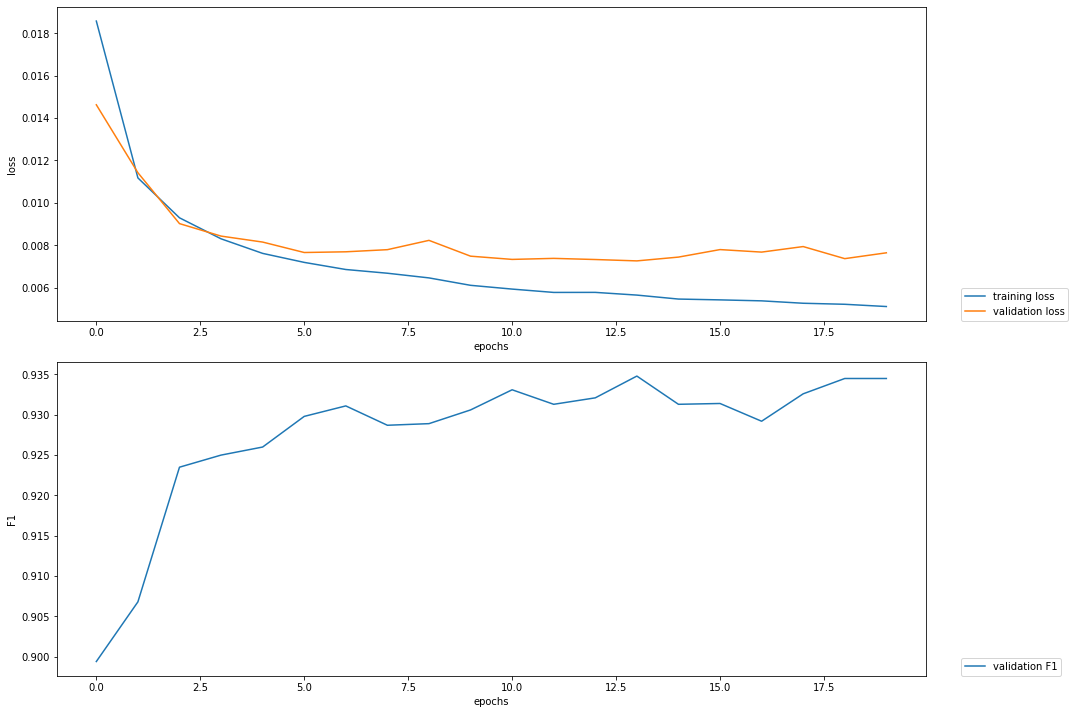

In [32]:
from flair.visual.training_curves import Plotter

plotter = Plotter()
plotter.plot_training_curves('model_output/loss.tsv')


In [30]:
!zip -r 'model_output.zip' ./model_output

updating: model_output/ (stored 0%)
  adding: model_output/loss.tsv (deflated 62%)
  adding: model_output/best-model.pt (deflated 8%)
  adding: model_output/weights.txt (stored 0%)
  adding: model_output/test.tsv (deflated 77%)
  adding: model_output/training.log (deflated 86%)
  adding: model_output/dev.tsv (deflated 75%)
  adding: model_output/final-model.pt (deflated 8%)
